In [1]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path
from torch import nn
from torchvision import datasets, transforms, models

from torchinfo import summary
from torchmetrics import ConfusionMatrix

from timeit import default_timer as timer
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm
from PIL import Image
from typing import List, Tuple

from scripts import engine
from scripts import helper_functions
from scripts import data_setup

import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data_path = Path('data')
image_path = data_path/'pizza_steak_sushi'

train_dir = image_path/'train'
test_dir = image_path/'test'

In [4]:
simple_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataloader, test_dataloader, class_list = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=simple_transforms,
    batch_size=32,
    num_workers=0
)

train_dataloader, test_dataloader, class_list

(<torch.utils.data.dataloader.DataLoader at 0x1f638991ca0>,
 ['pizza', 'steak', 'sushi'])

In [6]:
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights).to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
summary(model=model,
       input_size=[32,3,256,256],
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

C:\Users\antho\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 256, 256]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 256, 256]    [32, 64, 128, 128]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 128, 128]   [32, 64, 128, 128]   128                  True
├─ReLU (relu)                            [32, 64, 128, 128]   [32, 64, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
├─Sequential (layer1)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   True
│    └─BasicBlock (0)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 64, 64]     [32, 64, 64, 64]     36,864               True
│    │    └─BatchN

In [8]:
for param in model.parameters():
    param.requires_grad=False

In [9]:
summary(model=model,
       input_size=[32,3,256,256],
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 256, 256]    [32, 1000]           --                   False
├─Conv2d (conv1)                         [32, 3, 256, 256]    [32, 64, 128, 128]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 128, 128]   [32, 64, 128, 128]   (128)                False
├─ReLU (relu)                            [32, 64, 128, 128]   [32, 64, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
├─Sequential (layer1)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   False
│    └─BasicBlock (0)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 64, 64]     [32, 64, 64, 64]     (36,864)             False
│    │    └─

In [10]:
for param in model.fc.parameters():
    param.requires_grad=True

model.fc = nn.Linear(in_features=512, out_features=len(class_list), bias=True)

In [11]:
summary(model=model,
       input_size=[32,3,256,256],
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 256, 256]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 256, 256]    [32, 64, 128, 128]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 128, 128]   [32, 64, 128, 128]   (128)                False
├─ReLU (relu)                            [32, 64, 128, 128]   [32, 64, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
├─Sequential (layer1)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   False
│    └─BasicBlock (0)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 64, 64]     [32, 64, 64, 64]     (36,864)             False
│    │    

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
start_time = timer()

results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=10,
)

end_time = timer()
print(f"Total Training Time: {end_time - start_time:.4f} Seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.0689 | Train Accuracy: 0.4708 | Test Loss: 0.8355 | Test Accuracy: 0.6761
Epoch: 2 | Train Loss: 0.8265 | Train Accuracy: 0.6562 | Test Loss: 0.6386 | Test Accuracy: 0.8477
Epoch: 3 | Train Loss: 0.6605 | Train Accuracy: 0.7833 | Test Loss: 0.6062 | Test Accuracy: 0.8420
Epoch: 4 | Train Loss: 0.6139 | Train Accuracy: 0.7646 | Test Loss: 0.4796 | Test Accuracy: 0.8818
Epoch: 5 | Train Loss: 0.5228 | Train Accuracy: 0.8542 | Test Loss: 0.4454 | Test Accuracy: 0.9102
Epoch: 6 | Train Loss: 0.4641 | Train Accuracy: 0.8792 | Test Loss: 0.4108 | Test Accuracy: 0.9324
Epoch: 7 | Train Loss: 0.4662 | Train Accuracy: 0.8229 | Test Loss: 0.3520 | Test Accuracy: 0.9256
Epoch: 8 | Train Loss: 0.3968 | Train Accuracy: 0.9021 | Test Loss: 0.3351 | Test Accuracy: 0.9256
Epoch: 9 | Train Loss: 0.3689 | Train Accuracy: 0.8667 | Test Loss: 0.3281 | Test Accuracy: 0.9381
Epoch: 10 | Train Loss: 0.3809 | Train Accuracy: 0.8833 | Test Loss: 0.2959 | Test Accuracy: 0.9500
Total Tra

In [14]:
test_preds = []
model.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        pred_probs = torch.softmax(pred, dim=1)
        pred_labels = torch.argmax(pred_probs, dim=1)
        test_preds.append(pred_labels)

# We do a list comprehension on test_preds to transfer the device to cpu because if we keep it on cuda then it'll be hard to look at the 
# formation of the values because there would be device=''cuda:0' section
test_preds = [tensor.cpu() for tensor in test_preds]
print(f"Before Cat: {test_preds}\n")
# We apply concat because the tensors are seperated into batches and we want all of the values in one dimension.
test_preds = torch.cat(test_preds).cpu()
print(f"After Cat: {test_preds}")

100%|██████████████████████████| 5/5 [00:00<00:00,  6.04it/s]

Before Cat: [tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 2]), tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])]

After Cat: tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [15]:
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

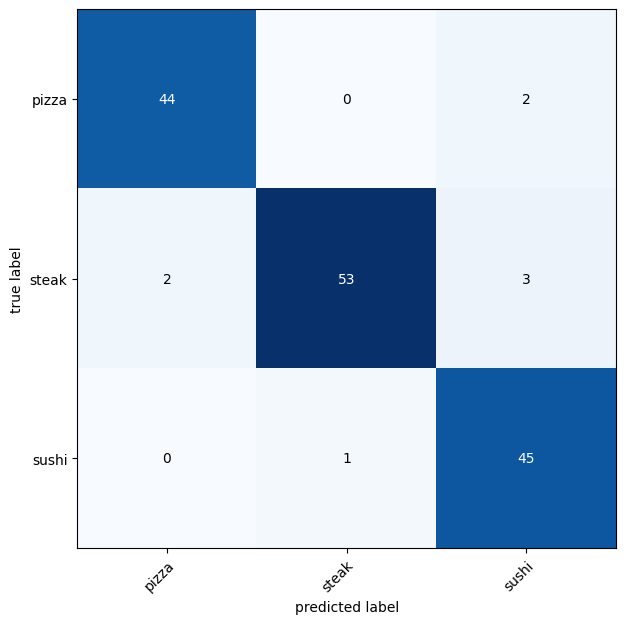

In [16]:
confmat = ConfusionMatrix(num_classes=len(class_list), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                        target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_list,
    figsize=(10,7)
)

In [17]:
# This gets all the test image paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# This gets all the associated classes for each image path
test_labels = [path.parent.stem for path in test_data_paths]

# This returns a list of dictionaries with sample, label, prediction, and prediction probability
def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        pred_dict = {}
        pred_dict["image_path"] = path
        pred_dict["class_name"] = path.parent.stem

        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0).to(device) # Transforms image + adds batch dimension
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

        pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
        pred_dict["pred_class"] = pred_class
        test_pred_list.append(pred_dict)

    return test_pred_list

In [18]:
pred_list = pred_and_store(test_data_paths, model, simple_transforms ,class_list , device)

100%|██████████████████████| 150/150 [00:01<00:00, 80.32it/s]


In [19]:
correct_df = pd.DataFrame(pred_list).sort_values(by='pred_prob', ascending=False)
correct_df_5 = correct_df.head(5)
correct_df_5

,image_path,class_name,pred_prob,pred_class
0,data\pizza_steak_sushi\test\pizza\1001116.jpg,pizza,0.993102,pizza
2,data\pizza_steak_sushi\test\pizza\1067986.jpg,pizza,0.992461,pizza
16,data\pizza_steak_sushi\test\pizza\2582289.jpg,pizza,0.991659,pizza
13,data\pizza_steak_sushi\test\pizza\2398925.jpg,pizza,0.987720,pizza
20,data\pizza_steak_sushi\test\pizza\2997525.jpg,pizza,0.985885,pizza


In [20]:
wrong_preds = [i for i in pred_list if i['pred_class'] != i['class_name']]

In [21]:
wrong_df = pd.DataFrame(wrong_preds).sort_values(by='pred_prob', ascending=False)
wrong_df_5 = wrong_df.head(5)
wrong_df_5

,image_path,class_name,pred_prob,pred_class
7,data\pizza_steak_sushi\test\sushi\2274102.jpg,sushi,0.663888,steak
4,data\pizza_steak_sushi\test\steak\3757027.jpg,steak,0.592197,sushi
0,data\pizza_steak_sushi\test\pizza\138961.jpg,pizza,0.576772,sushi
2,data\pizza_steak_sushi\test\steak\1982192.jpg,steak,0.529641,pizza
3,data\pizza_steak_sushi\test\steak\3553838.jpg,steak,0.500050,sushi


In [22]:
for index, row in wrong_df_5.iterrows():
    print(f'image_path: {row['image_path']}')
    print(f'class_name: {row['class_name']}')
    print(f'pred_prob: {row['pred_prob']}')
    print(f'pred_class: {row['pred_class']}')

image_path: data\pizza_steak_sushi\test\sushi\2274102.jpg
class_name: sushi
pred_prob: 0.6638877987861633
pred_class: steak
image_path: data\pizza_steak_sushi\test\steak\3757027.jpg
class_name: steak
pred_prob: 0.5921968221664429
pred_class: sushi
image_path: data\pizza_steak_sushi\test\pizza\138961.jpg
class_name: pizza
pred_prob: 0.5767724514007568
pred_class: sushi
image_path: data\pizza_steak_sushi\test\steak\1982192.jpg
class_name: steak
pred_prob: 0.5296409726142883
pred_class: pizza
image_path: data\pizza_steak_sushi\test\steak\3553838.jpg
class_name: steak
pred_prob: 0.5000497698783875
pred_class: sushi


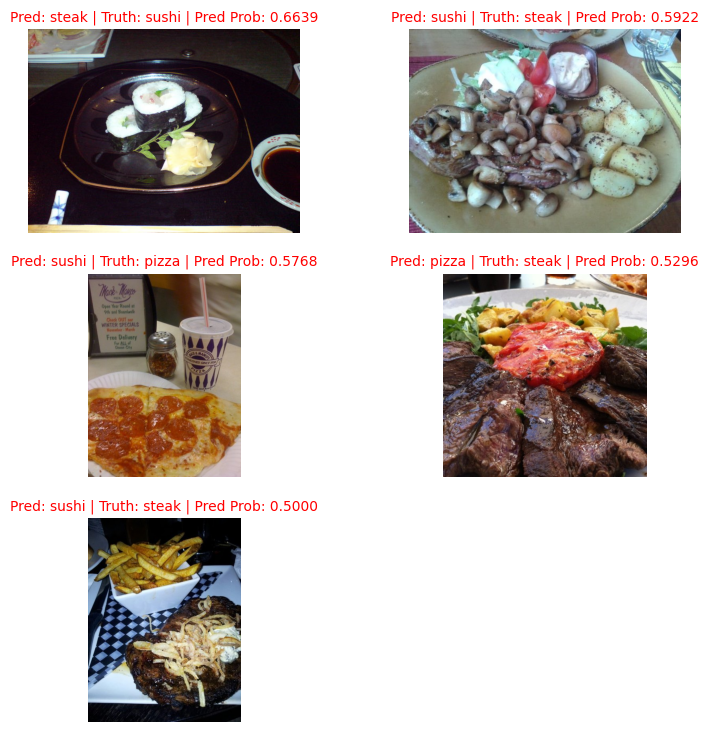

In [23]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 2
for idx, (index, row) in enumerate(wrong_df_5.iterrows(), start=1):
    # Create a subplot
    plt.subplot(nrows, ncols, idx)
    # Plot the target image
    plt.imshow(Image.open(row['image_path']), cmap="gray")
    # Finding the prediction label (in text form, e.g. "Sandal")
    pred_label = row['class_name']
    # Get the truth label (in text form e.g "T-shirt")
    truth_label = row['pred_class']
    # Create the title text of the plot
    title_text = f"Pred: {row['pred_class']} | Truth: {row['class_name']} | Pred Prob: {row['pred_prob']:.4f}"
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False);

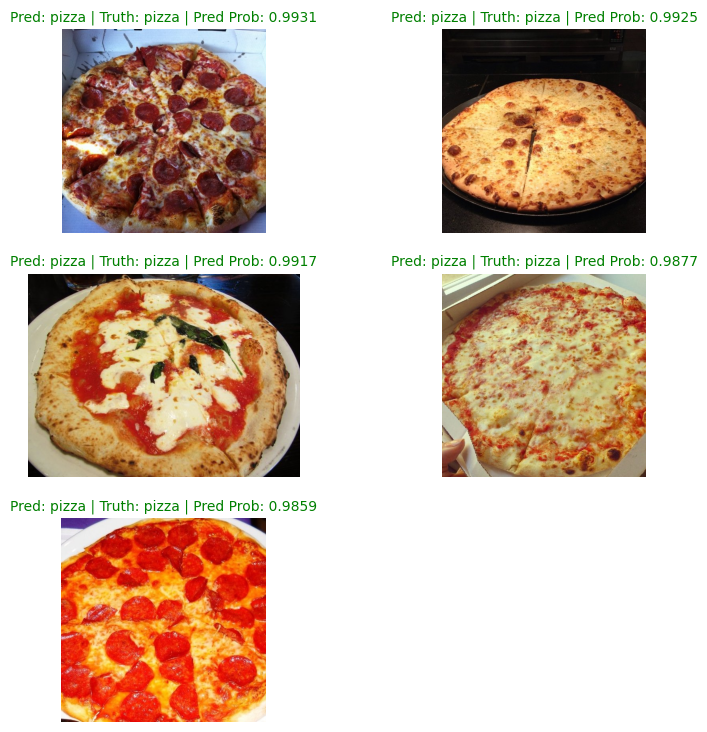

In [24]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 2
for idx, (index, row) in enumerate(correct_df_5.iterrows(), start=1):
    # Create a subplot
    plt.subplot(nrows, ncols, idx)
    # Plot the target image
    plt.imshow(Image.open(row['image_path']), cmap="gray")
    # Finding the prediction label (in text form, e.g. "Sandal")
    pred_label = row['class_name']
    # Get the truth label (in text form e.g "T-shirt")
    truth_label = row['pred_class']
    # Create the title text of the plot
    title_text = f"Pred: {row['pred_class']} | Truth: {row['class_name']} | Pred Prob: {row['pred_prob']:.4f}"
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False);

In [25]:
custom_image_path = Path('custom')
custom_image = custom_image_path/'image.jpg'

In [26]:
def pred_plot_image(
    model: torch.nn.Module,
    class_list: List[str],
    target_image: str,
    image_size: Tuple[int,int] = (256,256),
    transform: torchvision.transforms = None,
    device: torch.device = device
):
    image = Image.open(target_image)
    if transform:
        transformed_image = transform(image)
        
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = transformed_image.unsqueeze(dim=0).to(device)
        logits = model(transformed_image)
        
    probabilities = torch.softmax(logits, dim=1)
    labels = torch.argmax(probabilities, dim=1)

    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {class_list[labels.item()]} | Prob: {probabilities.max():.3f}")
    plt.axis()

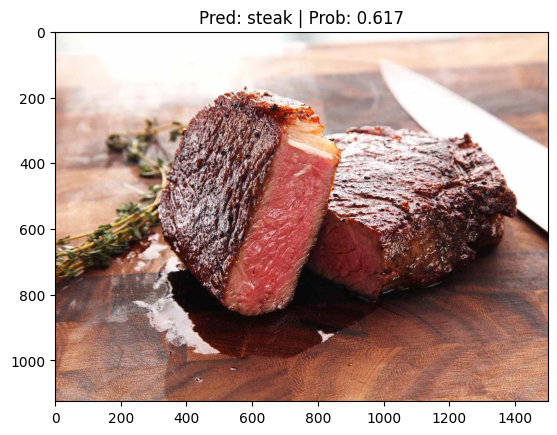

In [27]:
pred_plot_image(model, class_list, custom_image, (256,256), simple_transforms, device)